In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='nitk25')

In [2]:
import geemap

Map = geemap.Map()

point = ee.Geometry.Point([74.85, 12.95])  # Karnataka region
basin = point.buffer(20000)  # 20 km buffer

Map.centerObject(basin, 9)
Map.addLayer(basin, {}, "Watershed")
Map


Map(center=[12.950020517646063, 74.85000058383109], controls=(WidgetControl(options=['position', 'transparent_…

In [3]:
rain = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate("2020-01-01", "2020-12-31") \
        .filterBounds(basin) \
        .sum()

Map.addLayer(rain, {"min":0, "max":2000}, "Rainfall")


In [8]:
lulc = ee.Image("ESA/WorldCover/v100/2020")

Map.addLayer(lulc, {}, "LULC")


In [9]:
dem = ee.Image("USGS/SRTMGL1_003")

Map.addLayer(dem, {"min":0, "max":3000}, "DEM")


In [10]:
stack = rain.addBands(lulc).addBands(dem)


In [11]:
samples = stack.sample(
    region=basin,
    scale=1000,
    numPixels=1000,
    geometries=False
)

import pandas as pd
df = geemap.ee_to_df(samples)
df.head()


,Map,elevation,precipitation
0,80,0,4698.899600
1,80,0,4698.899600
2,80,0,4698.899600
3,80,0,4698.899600
4,10,15,4694.636597


In [12]:
df["Runoff"] = 0.3 * df["precipitation"]   # simple assumption


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X = df[["precipitation", "Map", "elevation"]]
y = df["Runoff"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))


R² Score: 0.999994565856143


In [14]:
model.feature_importances_


array([9.99693108e-01, 1.32070275e-05, 2.93684850e-04])

In [15]:
# Create comparison dataframe
comparison = X_test.copy()
comparison["Actual_Runoff"] = y_test.values
comparison["Predicted_Runoff"] = y_pred

# Show first 10 samples
comparison.head(10)


,precipitation,Map,elevation,Actual_Runoff,Predicted_Runoff
468,4457.863006,10,60,1337.358902,1337.538964
148,4599.136962,10,29,1379.741089,1379.741089
302,4730.214947,10,77,1419.064484,1419.064484
355,4683.301293,10,17,1404.990388,1404.990388
515,4451.800117,10,73,1335.540035,1335.540035
266,4730.214947,10,14,1419.064484,1419.064484
72,4678.591260,80,8,1403.577378,1403.577378
81,4717.142127,10,36,1415.142638,1415.127691
133,4661.303193,80,17,1398.390958,1398.390958
342,4634.648430,10,19,1390.394529,1390.460709


In [16]:
comparison["Error"] = comparison["Actual_Runoff"] - comparison["Predicted_Runoff"]
comparison["Absolute_Error"] = abs(comparison["Error"])

comparison.head()


,precipitation,Map,elevation,Actual_Runoff,Predicted_Runoff,Error,Absolute_Error
468,4457.863006,10,60,1337.358902,1337.538964,-1.800618e-01,1.800618e-01
148,4599.136962,10,29,1379.741089,1379.741089,-1.136868e-12,1.136868e-12
302,4730.214947,10,77,1419.064484,1419.064484,-2.728484e-12,2.728484e-12
355,4683.301293,10,17,1404.990388,1404.990388,1.136868e-12,1.136868e-12
515,4451.800117,10,73,1335.540035,1335.540035,-2.501110e-12,2.501110e-12


In [17]:
comparison["Absolute_Error"].mean()


np.float64(0.015681930303651215)

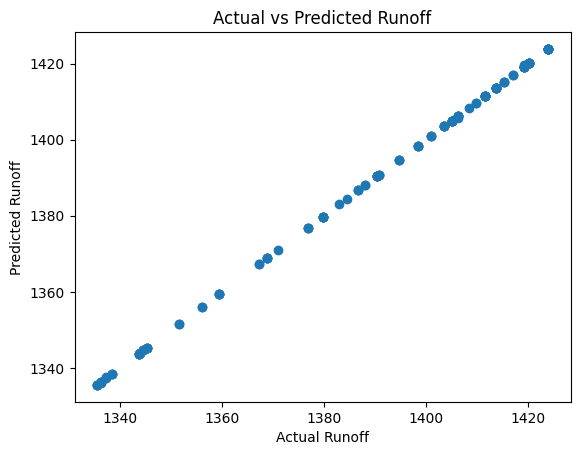

In [18]:
import matplotlib.pyplot as plt

plt.scatter(comparison["Actual_Runoff"], comparison["Predicted_Runoff"])
plt.xlabel("Actual Runoff")
plt.ylabel("Predicted Runoff")
plt.title("Actual vs Predicted Runoff")
plt.show()


In [19]:
comparison.sample(5)


,precipitation,Map,elevation,Actual_Runoff,Predicted_Runoff,Error,Absolute_Error
716,4557.248295,10,20,1367.174489,1367.289954,-1.154649e-01,1.154649e-01
208,4661.303193,10,87,1398.390958,1398.390958,-2.728484e-12,2.728484e-12
674,4505.527659,10,23,1351.658298,1351.658298,-1.591616e-12,1.591616e-12
33,4678.591260,10,21,1403.577378,1403.577378,0.000000e+00,0.000000e+00
44,4746.168743,80,0,1423.850623,1423.850623,0.000000e+00,0.000000e+00


In [20]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


MAE: 0.015681930303651215
